In [2]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

This is based on [YT video](https://www.youtube.com/watch?v=TCH_1BHY58I) and [original notebook](https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part2_mlp.ipynb)

Implementation is based on the paper [Bengio et. al (2000) "A Neural Probabilistic Language Model"](https://papers.nips.cc/paper_files/paper/2000/hash/728f206c2a01bf572b5940d7d9a8fa4c-Abstract.html)

In [3]:
words = open('../data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
chars = sorted(set(''.join(words)))
stoi = {char: i for i, char in enumerate(chars)}
stoi['.'] = 0
itos = {i: char for char, i in stoi.items()}


In [49]:
# build the dataset
block_size = 3 # context length, how many characters to look at to predict the next one
X, Y = [], []
for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # update the context with the new character

X  = torch.tensor(X)
Y = torch.tensor(Y)

yuheng
... ---> y
..y ---> u
.yu ---> h
yuh ---> e
uhe ---> n
hen ---> g
eng ---> .
diondre
... ---> d
..d ---> i
.di ---> o
dio ---> n
ion ---> d
ond ---> r
ndr ---> e
dre ---> .
xavien
... ---> x
..x ---> .
.x. ---> v
x.v ---> i
.vi ---> e
vie ---> n
ien ---> .
jori
... ---> j
..j ---> o
.jo ---> r
jor ---> i
ori ---> .
juanluis
... ---> j
..j ---> u
.ju ---> .
ju. ---> n
u.n ---> l
.nl ---> u
nlu ---> i
lui ---> s
uis ---> .


In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [6]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  4],
        [ 0,  4, 12],
        [ 4, 12, 12],
        [12, 12,  0],
        [ 0,  0,  0],
        [ 0,  0, 14],
        [ 0, 14, 11],
        [14, 11,  8],
        [11,  8, 21],
        [ 8, 21,  8],
        [21,  8,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0, 21],
        [ 0, 21,  0],
        [ 0,  0,  0],
        [ 0,  0,  8],
        [ 0,  8, 18],
        [ 8, 18,  0],
        [18,  0,  1],
        [ 0,  1,  4],
        [ 1,  4, 11],
        [ 4, 11, 11],
        [11, 11,  0],
        [ 0,  0,  0],
        [ 0,  0, 18],
        [ 0, 18, 14],
        [18, 14, 15],
        [14, 15,  7],
        [15,  7,  8],
        [ 7,  8,  0]])

In [50]:
# create a look up table C from the paper
# they use 30 dimensions
# we have e 27 characters and we cram them into 30 dimensions

C = torch.randn((27,2))


In [11]:
C[5]

tensor([ 0.5382, -1.0295])

In [10]:
# if we dont convert one-hot to float, we get error
# F.one_hot(torch.tensor(5), num_classes=27) @ C

F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 0.5382, -1.0295])

In [12]:
F.one_hot(torch.tensor(5), num_classes=27).float()

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

Above outputs are same. matrix multiplication takes the one-hot encoding and selects the row where its not zero and multiplies it with the matrix

In [13]:
C[torch.tensor([4,5,6,7,7,7,7])]

tensor([[ 0.5627,  0.5933],
        [ 0.5382, -1.0295],
        [-0.6382,  0.0475],
        [ 0.1791, -0.4160],
        [ 0.1791, -0.4160],
        [ 0.1791, -0.4160],
        [ 0.1791, -0.4160]])

In [14]:
# we can embed whole array at once
embed = C[X]
embed.shape

torch.Size([32, 3, 2])

In [38]:
#let's take the weight matrix
W1 = torch.randn((6,100))
b1 = torch.randn(100)


In [16]:
# now we wan to multiply the embedding with the weight matrix embed @ W1 + b1
# but embedding is 3D tensor, we need to flatten it to 2D tensor
# we can use reshape for that
# we cconcatenate the embedding
torch.cat([embed[:, 0, :], embed[:, 1, :], embed[:, 2, :]], dim=1).shape

torch.Size([32, 6])

In [19]:
# we can use torch.unbind to split the tenssor 
torch.cat(torch.unbind(embed, dim=1), 1).shape

torch.Size([32, 6])

In [22]:
# torch.view is more efficient way to do the same
embed.view(embed.shape[0],6)
# in the view we can also do view(-1,6), torch is smart enough to infer the shape
h = torch.tanh(embed.view(embed.shape[0],6) @ W1 + b1)

In [23]:
h.shape

torch.Size([32, 100])

In [39]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [25]:
logits = h @ W2 + b2

In [26]:
counts = logits.exp()

In [27]:
probs = counts / counts.sum(1, keepdim=True)

In [28]:
probs.shape

torch.Size([32, 27])

In [32]:
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(14.2740)

In [ ]:
# this is same as using F.cross_entropy
loss = F.cross_entropy(logits, Y)


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [34]:
Xtr.shape, Ytr.shape # dataset


(torch.Size([182625, 3]), torch.Size([182625]))

In [77]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [78]:
sum(p.nelement() for p in parameters) # total number of parameters

3481

In [79]:
# set requires_grad to True for all parameters
for p in parameters:
    p.requires_grad = True

In [54]:
for _ in range(1000):

    # forward pass
    embed = C[X] # (32, 3, 2)
    h = torch.tanh(embed.view(-1, 6) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27) 
    loss = F.cross_entropy(logits, Y) # scalar
    print('loss:', loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad
 
print('last loss:', loss.item())

loss: 20.854570388793945
loss: 16.714345932006836
loss: 14.018871307373047
loss: 11.882450103759766
loss: 10.184459686279297
loss: 8.851106643676758
loss: 7.739650249481201
loss: 6.815986633300781
loss: 6.032786846160889
loss: 5.379341125488281
loss: 4.826551914215088
loss: 4.338926315307617
loss: 3.901522636413574
loss: 3.509769916534424
loss: 3.1616530418395996
loss: 2.8547210693359375
loss: 2.5865306854248047
loss: 2.3533427715301514
loss: 2.14989972114563
loss: 1.9713270664215088
loss: 1.8133187294006348
loss: 1.6713929176330566
loss: 1.5417560338974
loss: 1.422067403793335
loss: 1.3112537860870361
loss: 1.2090882062911987
loss: 1.1157770156860352
loss: 1.031572937965393
loss: 0.9564790725708008
loss: 0.8901669383049011
loss: 0.8320931196212769
loss: 0.7816023230552673
loss: 0.7379186749458313
loss: 0.7001427412033081
loss: 0.667337954044342
loss: 0.6386278867721558
loss: 0.6132497787475586
loss: 0.5905656814575195
loss: 0.5700600147247314
loss: 0.5513244867324829
loss: 0.534040153

In [46]:
# in practice, we want to do passes on mini batches
torch.randint(0, X.shape[0], (32,)) # make 32 random samples from 0 to 4

tensor([16, 26, 10,  1, 19, 24, 29, 12, 23, 25,  3, 13, 24, 30,  2, 28, 26, 25,
        14,  5, 21,  5, 21,  8,  3,  2, 22,  0, 13,  5,  1, 16])

In [55]:
for _ in range(100):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    # forward pass
    embed = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(embed.view(-1, 6) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27) 
    loss = F.cross_entropy(logits, Y[ix]) # scalar
    print('loss:', loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad
 
print('last loss:', loss.item())

loss: 0.10544939339160919
loss: 0.1608457863330841
loss: 0.103232741355896
loss: 0.4509998559951782
loss: 0.2466307133436203
loss: 0.6032150983810425
loss: 0.24616625905036926
loss: 0.23650315403938293
loss: 0.22609512507915497
loss: 0.31527629494667053
loss: 0.2749767005443573
loss: 0.21669790148735046
loss: 0.37167707085609436
loss: 0.1897207796573639
loss: 0.08490179479122162
loss: 0.2376260906457901
loss: 0.34738442301750183
loss: 0.25320497155189514
loss: 0.24264325201511383
loss: 0.39709824323654175
loss: 0.2505528926849365
loss: 0.4715438783168793
loss: 0.19059784710407257
loss: 0.7082631587982178
loss: 0.39917346835136414
loss: 0.2853988707065582
loss: 0.36782464385032654
loss: 0.21827231347560883
loss: 0.29489463567733765
loss: 0.2702743411064148
loss: 0.16897785663604736
loss: 0.223593071103096
loss: 0.33973458409309387
loss: 0.2374323010444641
loss: 0.22411127388477325
loss: 0.2844162881374359
loss: 0.10238781571388245
loss: 0.2609926760196686
loss: 0.2998398244380951
loss: 

In [48]:
# get the loss for all data instead of mini batches
embed = C[X]
h = torch.tanh(embed.view(X.shape[0], 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print('loss:', loss.item())

loss: 0.35736072063446045


In [76]:
# how to set the learning rate
# let's say lr is somewhere between -1 and -0.001 and we want to sample uniformly

lre = torch.linspace(-3, 0, 1000)
lrs  = 10**lre

In [69]:
lri = []
lossi = []
for i in range(1000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    # forward pass
    embed = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(embed.view(-1, 6) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27) 
    loss = F.cross_entropy(logits, Y[ix]) # scalar
    print('loss:', loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    lri.append(lr)
    lossi.append(loss.item())
 
print('last loss:', loss.item())

loss: 1.6471240520477295
loss: 1.1050370931625366
loss: 0.45170408487319946
loss: 0.9960702657699585
loss: 0.6539334058761597
loss: 2.205263614654541
loss: 0.6113002896308899
loss: 1.099347472190857
loss: 1.0990524291992188
loss: 1.0975227355957031
loss: 2.084169864654541
loss: 0.7611526250839233
loss: 2.979553699493408
loss: 1.0928535461425781
loss: 1.4810128211975098
loss: 0.8061668276786804
loss: 1.4292339086532593
loss: 2.0746474266052246
loss: 0.7558736801147461
loss: 0.6015254259109497
loss: 1.1354448795318604
loss: 3.000978708267212
loss: 1.2390151023864746
loss: 2.0614237785339355
loss: 1.576216697692871
loss: 1.8599599599838257
loss: 1.8102948665618896
loss: 1.4647505283355713
loss: 0.943548858165741
loss: 1.2282273769378662
loss: 1.5615675449371338
loss: 1.7152401208877563
loss: 0.9259647727012634
loss: 1.3640387058258057
loss: 2.0423192977905273
loss: 1.0697449445724487
loss: 1.7914586067199707
loss: 1.50644052028656
loss: 1.5490458011627197
loss: 1.978520154953003
loss: 0.9

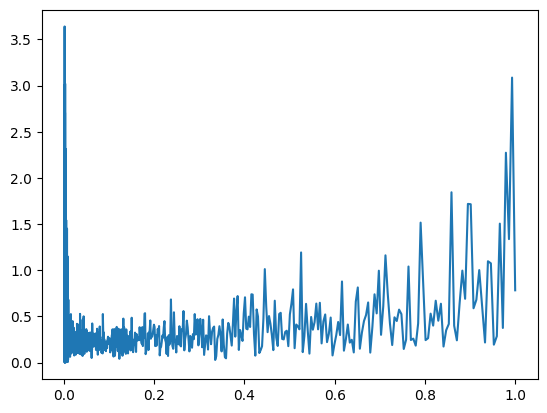

In [70]:
# learning rate is when it is lowest on th efollowing plot
plt.plot(lri, lossi)

In [80]:
# do not track the  lr but track the exponent
lri = []
lossi = []
for i in range(1000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    # forward pass
    embed = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(embed.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27) 
    loss = F.cross_entropy(logits, Y[ix]) # scalar
    print('loss:', loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    # lri.append(lr)
    lri.append(lre[i])
    lossi.append(loss.item())
 
print('last loss:', loss.item())

loss: 21.102365493774414
loss: 23.893077850341797
loss: 22.403444290161133
loss: 18.3233699798584
loss: 18.38846778869629
loss: 21.738252639770508
loss: 22.855182647705078
loss: 19.903751373291016
loss: 20.51044464111328
loss: 19.358121871948242
loss: 19.54828453063965
loss: 16.465465545654297
loss: 19.86675453186035
loss: 18.703371047973633
loss: 21.162071228027344
loss: 17.771703720092773
loss: 20.064741134643555
loss: 19.46962547302246
loss: 21.206382751464844
loss: 21.144699096679688
loss: 15.28776741027832
loss: 20.70504379272461
loss: 18.700410842895508
loss: 20.504714965820312
loss: 19.104780197143555
loss: 17.605066299438477
loss: 22.195287704467773
loss: 20.575952529907227
loss: 16.74392318725586
loss: 17.876976013183594
loss: 20.796932220458984
loss: 20.042238235473633
loss: 18.311811447143555
loss: 19.974246978759766
loss: 20.745849609375
loss: 20.94623374938965
loss: 15.942597389221191
loss: 18.189640045166016
loss: 18.43539047241211
loss: 17.36546516418457
loss: 19.4632396

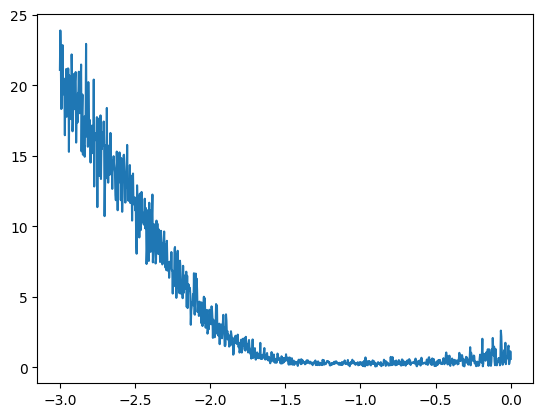

In [81]:
plt.plot(lri, lossi)

In [83]:
for i in range(10000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    # forward pass
    embed = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(embed.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27) 
    loss = F.cross_entropy(logits, Y[ix]) # scalar
    # print('loss:', loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    # lr = lrs[i]
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
    # lri.append(lr)
    # lri.append(lre[i])
    # lossi.append(loss.item())
 
print('last loss:', loss.item())

last loss: 0.5610748529434204


In [90]:
# use train test split to address the overfitting
# make everything a function
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [96]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
# set requires_grad to True for all parameters
for p in parameters:
    p.requires_grad = True

In [97]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [98]:
lri = []
lossi = []
stepi = []

In [99]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

2.16683292388916


In [100]:
embed = C[Xtr]
h = torch.tanh(embed.view(Xtr.shape[0], 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print('train loss:', loss.item())

train loss: 2.174825668334961


In [101]:
embed = C[Xdev]
h = torch.tanh(embed.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print('train loss:', loss.item())

train loss: 2.1812448501586914


KeyError: 26

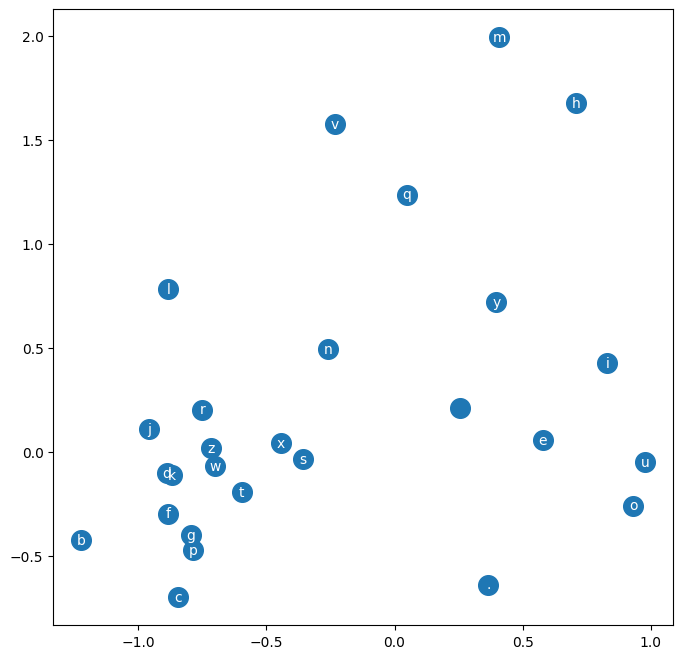

In [102]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

Increase the embedding size as we are craming too many characters into 2-dimensional embeddings

In [107]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
# set requires_grad to True for all parameters
for p in parameters:
    p.requires_grad = True

In [108]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

2.105987548828125


In [110]:
embed = C[Xtr]
h = torch.tanh(embed.view(Xtr.shape[0], 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print('train loss:', loss.item())

train loss: 2.518852710723877


In [111]:
embed = C[Xdev]
h = torch.tanh(embed.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print('train loss:', loss.item())

train loss: 2.537611722946167
